# Pythia in Python + Train Binary Classifier in PyTorch
This tutorial uses Pythia8 in python3 to generate a ttbar signal dataset and a QCD background dataset. A neural network is then trained to distinguish between signal and background.

### Download, Unpack, and Configure Pythia
In the configuration summary make sure PYTHON is listed as an external package that will be used.

In [ ]:
!curl -O https://www.pythia.org/download/pythia83/pythia8312.tgz
!tar xfz pythia8312.tgz
%cd pythia8312
!./configure --with-python-config=python3-config

### Compile Pythia
This takes a few minutes. If you have more cores, increase the -jN to match your number of cpu cores.

In [ ]:
%%time
!make -j4

In [1]:
%cd pythia8312

/home/lvaughan/ML_Tutorial_2025/pythia8312


### Import Pythia and Other Dependencies
The Makefile.inc in the pythia8312 directory includes some paths that must be added to your system paths in order to import pythia into python. If you are able to run this block, then your setup was successful!

In [2]:
# Add the necessary pythia build paths to the python paths
import sys
cfg = open("Makefile.inc")  # Read necessary paths from this file
lib = "../lib"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break  # Find build paths
sys.path.insert(0, lib)   # Add build paths to system path

In [3]:
# Import Pythia8
import pythia8

# Import Tensor Libs
import numpy as np
import awkward as ak

# Import ML Libs
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Import Plotting Libs
import matplotlib.pyplot as plt

### Initialize Pythia with Signal and Background Processes

In [ ]:
pythia_sig = pythia8.Pythia()                  # Define a pythia8.Pythia() object
pythia_sig.readString("Beams:eCM = 14000.")    # Beam energy is 14TeV
pythia_sig.readString("Beams:idA = 2212")      # Incoming particle 1 is proton
pythia_sig.readString("Beams:idB = 2212")      # Incoming particle 2 is proton
pythia_sig.readString("Top:qqbar2ttbar = on")          # Turn on all top processes
pythia_sig.init()                              # Initialize object with user defined settings

In [ ]:
pythia_bkg = pythia8.Pythia()                  # Define a pythia8.Pythia() object
pythia_bkg.readString("Beams:eCM = 14000.")    # Beam enegery is 14TeV
pythia_bkg.readString("Beams:idA = 2212")      # Incoming particle 1 is proton
pythia_bkg.readString("Beams:idB = 2212")      # Incoming particle 2 is proton
pythia_bkg.readString("WeakDoubleBoson:ffbar2WW = on")      # Turn on all HardQCD processes
pythia_bkg.init()                              # Initialize object with user defined settings

### Generate Dataset
Generate events and append stable particles to a list. Then histogram pT, eta, and phi for signal vs background.

In [ ]:
num_events = 10000

In [ ]:
# Begin event loop. Generate event. Skip if error.
sig_events = []
for iEvent in range(num_events):           # Loop through events
    event_sig = []
    if iEvent%5==0:
        print("Generating Signal: ", iEvent, " / ", num_events, end="\r")
    if not pythia_sig.next(): continue     # Standard pythia syntax to trigger next event generation
    for prt in pythia_sig.event:           # Loop through particles in each event
        if prt.isFinal():                  # Check if particle is final state particle and store pT, eta, phi
            event_sig.append([prt.pT(),prt.eta(),prt.phi()])
    sig_events.append(event_sig)
print("Done Generating Signal: ", num_events, " / ", num_events)

In [ ]:
# Begin event loop. Generate event. Skip if error.
bkg_events = []
for iEvent in range(num_events):          # Loop through events
    event_bkg = []
    if iEvent%5==0:
        print("Generating Background: ", iEvent, " / ", num_events, end="\r")
    if not pythia_bkg.next(): continue    # Standard pythia syntax to trigger enxt event generation
    for prt in pythia_bkg.event:          # Loop through particles in each event
        if prt.isFinal():                 # Chekc if particle is final stat particle and store pT, eta, phi
            event_bkg.append([prt.pT(),prt.eta(),prt.phi()])
    bkg_events.append(event_bkg)
print("Done Generating Background: ", num_events, " / ", num_events)

In [ ]:
sig_events = ak.Array(sig_events)
bkg_events = ak.Array(bkg_events)

In [ ]:
plt.title("Num Tracks per Event")
plt.hist(ak.num(sig_events),histtype='step',color='r',range=(0,1000),bins=30,label='sig')
plt.hist(ak.num(bkg_events),histtype='step',color='b',range=(0,1000),bins=30,label='bkg')
plt.legend()
plt.show()

In [ ]:
# Plot pT for signal and background
plt.title("Particle p$\mathregular{_{T}}$")
plt.hist(ak.ravel(sig_events[:,:,0]),bins=40,range=(0,100),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(bkg_events[:,:,0]),bins=40,range=(0,100),histtype='step',label='bkg',color='b',density=True)
plt.yscale('log')
plt.legend()
plt.show()

# Plot eta for signal and background
plt.title("Particle \u03B7")
plt.hist(ak.ravel(sig_events[:,:,1]),bins=30,range=(-10,10),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(bkg_events[:,:,1]),bins=30,range=(-10,10),histtype='step',label='bkg',color='b',density=True)
plt.legend()
plt.show()

# Plot phi for signal and background
plt.title("Particle \u03D5")
plt.hist(ak.ravel(sig_events[:,:,2]),bins=16,range=(-4,4),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(bkg_events[:,:,2]),bins=16,range=(-4,4),histtype='step',label='bkg',color='b',density=True)
plt.legend()
plt.show()

In [ ]:
sorted_args = ak.argsort(sig_events[:,:,0], ascending=False)
sorted_sig = sig_events[sorted_args]
sig_labels = np.ones((len(sorted_sig),1))

sorted_args = ak.argsort(bkg_events[:,:,0], ascending=False)
sorted_bkg = bkg_events[sorted_args]
bkg_labels = np.zeros((len(sorted_bkg),1))

combined_data = ak.concatenate([sorted_sig,sorted_bkg], axis=0)
combined_labels = ak.concatenate([sig_labels,bkg_labels], axis=0)

p = np.random.permutation(len(combined_data))
combined_data = combined_data[p]
combined_labels = combined_labels[p]

In [14]:
padding_particle_cutoff = 100

In [ ]:
padded_data = []
for i, event in enumerate(combined_data):
    if i%5==0:
        print("Padding Dataset: ", i, " / ", len(combined_data), end="\r")
    event_data = []
    for j in range(padding_particle_cutoff):
        if j<len(event):
            event_data.append(event[j])
        else:
            event_data.append([0,0,0])
    padded_data.append(event_data)
print("Done Padding Dataset: ", len(combined_data), " / ", len(combined_data))

print("Converting to Awkward Array...")
padded_data = ak.Array(padded_data)
print("Done Converting to Awkward Array")

In [ ]:
sig = combined_labels==1
bkg = combined_labels==0

In [ ]:
# Plot pT for signal and background
plt.title("Particle p$\mathregular{_{T}}$")
plt.hist(ak.ravel(padded_data[sig][:,0]),bins=40,range=(0,200),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(padded_data[bkg][:,0]),bins=40,range=(0,200),histtype='step',label='bkg',color='b',density=True)
plt.yscale('log')
plt.legend()
plt.show()

# Plot eta for signal and background
plt.title("Particle \u03B7")
plt.hist(ak.ravel(padded_data[sig][:,1]),bins=40,range=(-10,10),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(padded_data[bkg][:,1]),bins=40,range=(-10,10),histtype='step',label='bkg',color='b',density=True)
plt.yscale('log')
plt.legend()
plt.show()

# Plot phi for signal and background
plt.title("Particle \u03D5")
plt.hist(ak.ravel(padded_data[sig][:,2]),bins=40,range=(-4,4),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(padded_data[bkg][:,2]),bins=40,range=(-4,4),histtype='step',label='bkg',color='b',density=True)
plt.yscale('log')
plt.legend()
plt.show()

### Split Dataset Into Training and Testing Samples
It's best practice to use a training and testing dataset to verify that your model is not overfitting. Its also best practice to shuffle the dataset before training.

In [5]:
# Check if GPU is available, if not use cpu
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU Available:  True


In [6]:
class ParticleDataset(Dataset):
    def __init__(self, data, labels, device):
        self.data = torch.tensor(data, dtype=torch.float32).to(device)
        self.labels = torch.tensor(labels, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        event = self.data[idx]
        label = self.labels[idx]
        return event, label

In [ ]:
train_split = int(0.7*len(padded_data))
test_split = int(0.75*len(padded_data))

In [ ]:
train_dataset = ParticleDataset(padded_data[0:train_split], combined_labels[0:train_split], device)
val_dataset = ParticleDataset(padded_data[train_split:test_split], combined_labels[train_split:test_split], device)
test_dataset = ParticleDataset(padded_data[test_split:], combined_labels[test_split:], device)

torch.save(train_dataset, "train_dataset_20k.pt")
torch.save(val_dataset, "val_dataset_20k.pt")
torch.save(test_dataset, "test_dataset_20k.pt")

In [7]:
train_dataset = torch.load("train_dataset_20k.pt", weights_only=False)
val_dataset = torch.load("val_dataset_20k.pt", weights_only=False)
test_dataset = torch.load("test_dataset_20k.pt", weights_only=False)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [8]:
for inputs, labels in train_dataloader:
    print("Batch shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    break

Batch shape: torch.Size([256, 100, 3])
Labels shape: torch.Size([256, 1])


### Define the Model and the Training Loop

In [9]:
# Define the Model
class MultiLayerPerceptron(nn.Module):
    '''
    A DL model with customizable layers and nodes. 
    '''
    def __init__(self, in_dim, hidden_dim, num_layers, out_dim):
        super(MultiLayerPerceptron, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, hidden_dim))
        hidden_layers = [hidden_dim]*num_layers
        for nodes in hidden_layers:
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, 1))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        for layer in self.layers:
            x = F.gelu(layer(x))
        return F.sigmoid(x)

In [10]:
# Define a class that inherits from torch.nn.Module
class DeepSets(nn.Module):
    '''
    A DeepSets model that performs graph level classification on a dense graph. 
    '''
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(DeepSets, self).__init__()
        self.init = nn.Linear(in_dim, hidden_dim)
        self.Messages = nn.Linear(hidden_dim,hidden_dim)
        self.PostProcess = nn.Linear(hidden_dim,hidden_dim)
        self.Classification = nn.Linear(hidden_dim,out_dim)
    def forward(self, data):
        track_embedding = F.gelu(self.init(data))
        messages = F.gelu(self.Messages(track_embedding))
        aggregated_message = torch.sum(messages,dim=1)
        event_embedding = F.gelu(self.PostProcess(aggregated_message))
        output = F.sigmoid(self.Classification(event_embedding))
        return output

In [11]:
# Define a class that inherits from torch.nn.Module
class TransformerEncoder(nn.Module):
    '''
    An Attention model that performs set level classification on a set. 
    '''
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(TransformerEncoder, self).__init__()
        self.init = nn.Linear(in_dim, hidden_dim)
        self.Attention = nn.TransformerEncoderLayer(d_model=hidden_dim,dim_feedforward=hidden_dim, nhead=1, batch_first=True)        # Define linear transformation 1
        self.Classification = nn.Linear(hidden_dim,out_dim)
    def forward(self, data):
        embedding = F.gelu(self.init(data))
        embedding = F.gelu(self.Attention(embedding))
        embedding = torch.sum(embedding,dim=1)
        output = F.sigmoid(self.Classification(embedding))
        return output

In [12]:
# Define the training loop
def train(model, train_dataloader, val_dataloader, epochs=20):

    history = {'train_loss':[],'test_loss':[]}     # Define history dictionary

    # Loop through epoches
    for e in range(epochs):
        for X_train, y_train in train_dataloader:
            # Train Model
            model.train()                        # Switch model to training mode
            optimizer.zero_grad()                # Reset the optimizers gradients
            y_pred = model(X_train)             # Get the model prediction
            loss = loss_fn(y_pred, y_train)     # Evaluate loss function
            loss.backward()                      # Backward propogation
            optimizer.step()                     # Gradient Descent
        for X_val, y_val in val_dataloader:
            # Validate Model
            model.eval()
            y_pred = model(X_val)    # Get model output on test data
            test_loss = loss_fn(y_pred,y_val)   # Evaluate loss on test preditions
        
        history['train_loss'].append(loss.detach().cpu().numpy())        # Append train loss to history (detach and convert to numpy array)
        history['test_loss'].append(test_loss.detach().cpu().numpy())    # Append test loss to history (detach and convert to numpy array)
        if (e+1)%5==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(loss),4),'\tTest Loss:',round(float(test_loss),4))

    return history

### Train Model and Plot Training History

MultiLayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=300, out_features=32, bias=True)
    (1-4): 4 x Linear(in_features=32, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)
Trainable Parameters:  13889 

Epoch: 5 	Train Loss: 0.6969 	Test Loss: 0.6912
Epoch: 10 	Train Loss: 0.6914 	Test Loss: 0.6894
Epoch: 15 	Train Loss: 0.6891 	Test Loss: 0.6916
Epoch: 20 	Train Loss: 0.6979 	Test Loss: 0.6975
Epoch: 25 	Train Loss: 0.6926 	Test Loss: 0.699
Epoch: 30 	Train Loss: 0.6886 	Test Loss: 0.6944
Epoch: 35 	Train Loss: 0.6962 	Test Loss: 0.6883
Epoch: 40 	Train Loss: 0.6932 	Test Loss: 0.6974
Epoch: 45 	Train Loss: 0.7012 	Test Loss: 0.7004
Epoch: 50 	Train Loss: 0.7021 	Test Loss: 0.6888
Epoch: 55 	Train Loss: 0.6941 	Test Loss: 0.6937
Epoch: 60 	Train Loss: 0.7002 	Test Loss: 0.6879
Epoch: 65 	Train Loss: 0.6902 	Test Loss: 0.6928
Epoch: 70 	Train Loss: 0.689 	Test Loss: 0.6956
Epoch: 75 	Train Loss: 0.6918 	Test Loss: 0.6927

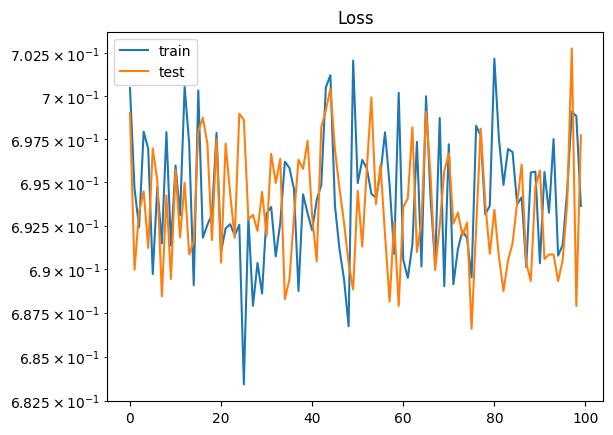

In [16]:
# Initialize model
MLP = MultiLayerPerceptron(in_dim=3*padding_particle_cutoff,hidden_dim=32, num_layers=4, out_dim=1)    # Declare model using NeuralNet Class
MLP.to(device)                                       # Put model on device (cpu or gpu)
print(MLP)                                           # Print layers in model

# Calculate and print trainable parameters
pytorch_total_params = sum(p.numel() for p in MLP.parameters() if p.requires_grad)
print("Trainable Parameters: ", pytorch_total_params,"\n")

# Declare optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.00001)  # Adam = Adaptive Moment Estimation, lr = learning rate
loss_fn = nn.BCELoss()                                 # BCE = Binary Cross Entropy, used for binary classification

#Train Model
history = train(MLP, train_dataloader, val_dataloader, epochs=100)                                             # Train the model!

# Plot Training History
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.yscale('log')
plt.show()

DeepSets(
  (init): Linear(in_features=3, out_features=16, bias=True)
  (Messages): Linear(in_features=16, out_features=16, bias=True)
  (PostProcess): Linear(in_features=16, out_features=16, bias=True)
  (Classification): Linear(in_features=16, out_features=1, bias=True)
)
Trainable Parameters:  625 

Epoch: 5 	Train Loss: 12.3098 	Test Loss: 12.6246
Epoch: 10 	Train Loss: 14.1025 	Test Loss: 14.5323
Epoch: 15 	Train Loss: 11.7549 	Test Loss: 13.3139
Epoch: 20 	Train Loss: 10.2888 	Test Loss: 15.4131
Epoch: 25 	Train Loss: 13.1591 	Test Loss: 15.7957
Epoch: 30 	Train Loss: 13.5749 	Test Loss: 12.7206
Epoch: 35 	Train Loss: 13.7979 	Test Loss: 13.5536
Epoch: 40 	Train Loss: 11.2238 	Test Loss: 16.5551
Epoch: 45 	Train Loss: 11.0901 	Test Loss: 13.7952
Epoch: 50 	Train Loss: 13.2272 	Test Loss: 15.9569
Epoch: 55 	Train Loss: 13.479 	Test Loss: 12.7209
Epoch: 60 	Train Loss: 12.7238 	Test Loss: 14.1932
Epoch: 65 	Train Loss: 17.2113 	Test Loss: 13.627
Epoch: 70 	Train Loss: 14.0384 	Test

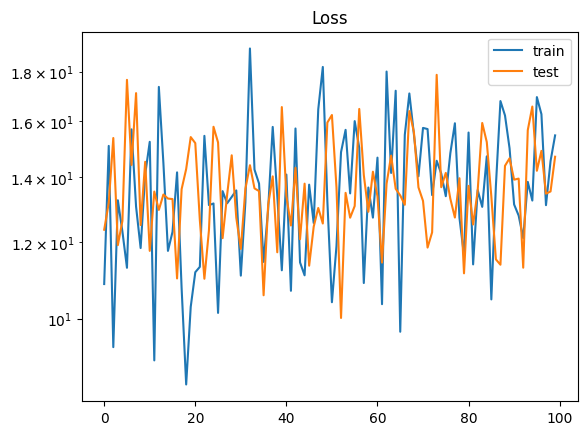

In [17]:
# Initialize model
GNN = DeepSets(in_dim=3,hidden_dim=16,out_dim=1)    # Declare model using NeuralNet Class
GNN.to(device)                                       # Put model on device (cpu or gpu)
print(GNN)                                           # Print layers in model

# Calculate and print trainable parameters
pytorch_total_params = sum(p.numel() for p in GNN.parameters() if p.requires_grad)
print("Trainable Parameters: ", pytorch_total_params,"\n")

# Declare optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.00001)  # Adam = Adaptive Moment Estimation, lr = learning rate
loss_fn = nn.BCELoss()                                 # BCE = Binary Cross Entropy, used for binary classification

#Train Model
history = train(GNN, train_dataloader, val_dataloader, epochs=100)                                             # Train the model!

# Plot Training History
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.yscale('log')
plt.show()

MultiLayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=300, out_features=32, bias=True)
    (1-4): 4 x Linear(in_features=32, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)
Trainable Parameters:  1777 

Epoch: 5 	Train Loss: 9.8662 	Test Loss: 7.8655
Epoch: 10 	Train Loss: 6.7989 	Test Loss: 7.5669
Epoch: 15 	Train Loss: 9.83 	Test Loss: 10.7143
Epoch: 20 	Train Loss: 6.8196 	Test Loss: 11.1065
Epoch: 25 	Train Loss: 10.7444 	Test Loss: 9.5384
Epoch: 30 	Train Loss: 9.3627 	Test Loss: 9.6335
Epoch: 35 	Train Loss: 9.0536 	Test Loss: 10.5697
Epoch: 40 	Train Loss: 9.1477 	Test Loss: 8.9674
Epoch: 45 	Train Loss: 8.0722 	Test Loss: 8.8709
Epoch: 50 	Train Loss: 6.8987 	Test Loss: 11.8574
Epoch: 55 	Train Loss: 9.6188 	Test Loss: 10.1737
Epoch: 60 	Train Loss: 6.0744 	Test Loss: 11.9097
Epoch: 65 	Train Loss: 9.8745 	Test Loss: 11.1898
Epoch: 70 	Train Loss: 8.1004 	Test Loss: 9.7614
Epoch: 75 	Train Loss: 8.0434 	Test Loss:

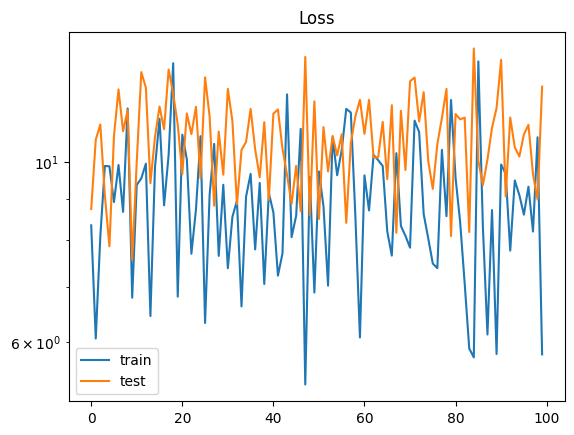

In [18]:
# Initialize model
Transformer = TransformerEncoder(in_dim=3,hidden_dim=16,out_dim=1)    # Declare model using NeuralNet Class
Transformer.to(device)                                       # Put model on device (cpu or gpu)
print(model)                                           # Print layers in model

# Calculate and print trainable parameters
pytorch_total_params = sum(p.numel() for p in Transformer.parameters() if p.requires_grad)
print("Trainable Parameters: ", pytorch_total_params,"\n")

# Declare optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.00001)  # Adam = Adaptive Moment Estimation, lr = learning rate
loss_fn = nn.BCELoss()                                 # BCE = Binary Cross Entropy, used for binary classification

#Train Model
history = train(Transformer, train_dataloader, val_dataloader, epochs=100)                                             # Train the model!

# Plot Training History
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.yscale('log')
plt.show()

In [48]:
# Define traditional ROC curve
def roc(y_pred,y_true):    
    sig_eff = []
    bkg_eff = []
    
    # Iterate over thresholds and calculate sig and bkg efficiency
    for threshold in np.linspace(0,1,50):
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))   # Sum over sig predictions > threshold and divide by total number of true sig instances 
        bkg_eff.append(((y_pred[bkg] < threshold).sum()  / y_true[bkg].shape[0]))  # Sum over bkg predictions < threshold and divide by total number of true bkg instances 
        
    return sig_eff, bkg_eff

# Define ATLAS Style ROC curve
def ATLAS_roc(y_pred,y_true):
    sig_eff = []
    bkg_eff = []
    
    thresholds = np.linspace(0,0.9,50)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(1-((y_pred[bkg] < threshold).sum()  / y_true[bkg].shape[0]))
        
    bkg_rej = [1/x for x in bkg_eff]  # ATLAS inverts bkg eff and uses bkg rejection instead
    return sig_eff, bkg_rej, thresholds

In [49]:
def eval_model(model):
    # Get Models predictions
    prediction = []
    truth = []
    test_loss = []
    for X_test, y_test in test_dataloader:
        model.eval()
        y_pred = model(X_test)    # Get model output on test data
        prediction.append(y_pred.detach().cpu().numpy())
        truth.append(y_test.detach().cpu().numpy())
        test_loss.append(loss_fn(y_pred,y_test))   # Evaluate loss on test preditions

    prediction = np.array(ak.ravel(prediction))
    truth = np.array(ak.ravel(truth))
    
    # Find indices of sig and bkg labels
    sig = np.where(truth==1)
    bkg = np.where(truth==0)

    # Plot Model Predictions
    plt.title(model.__class__.__name__+" Predictions")
    plt.hist(prediction[sig],histtype='step',color='r',label="sig")
    plt.hist(prediction[bkg],histtype='step',color='b',label="bkg")
    plt.xlabel("Model Score")
    plt.ylabel("Events")
    #plt.yscale('log')
    plt.legend()
    plt.show()
    
    return prediction, truth

/tmp/ipykernel_286276/2659254065.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  prediction = np.array(ak.ravel(prediction))
/tmp/ipykernel_286276/2659254065.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  truth = np.array(ak.ravel(truth))


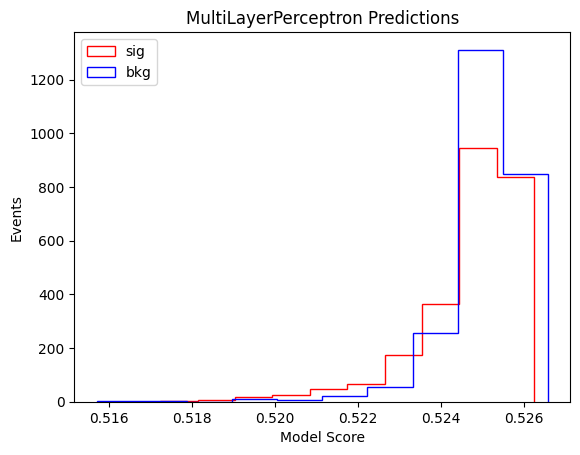

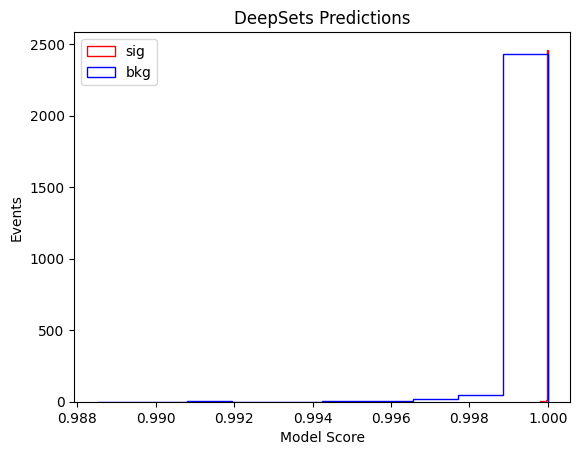

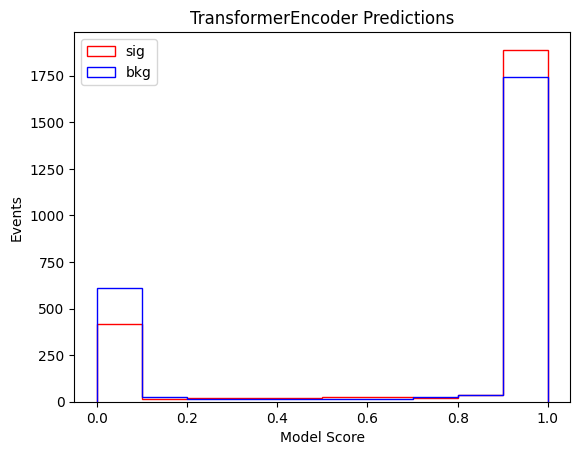

In [50]:
MLP_pred, MLP_true = eval_model(MLP)
GNN_pred, GNN_true = eval_model(GNN)
Trans_pred, Trans_true = eval_model(Transformer)

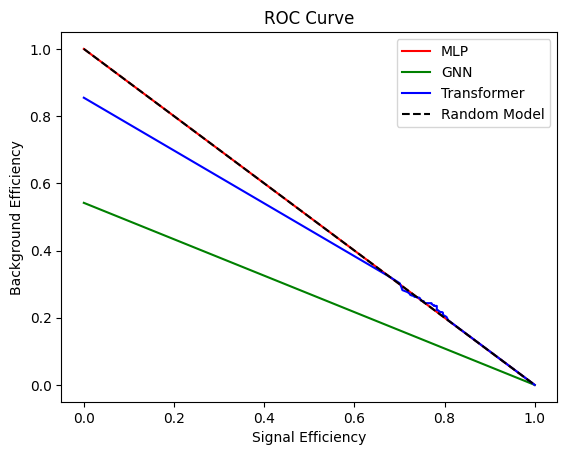

/tmp/ipykernel_286276/3020395189.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  bkg_rej = [1/x for x in bkg_eff]  # ATLAS inverts bkg eff and uses bkg rejection instead


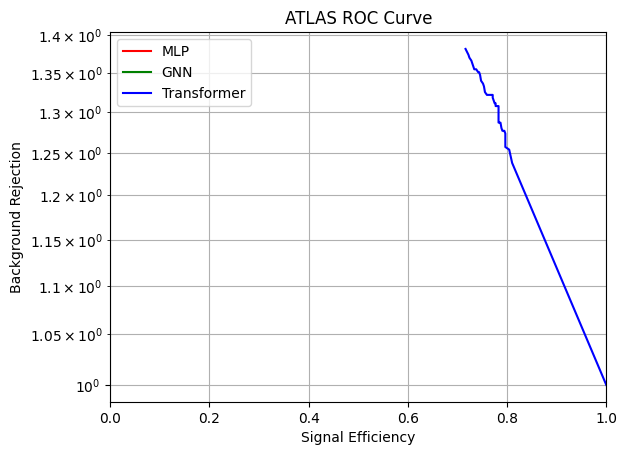

In [53]:
# Plot Tradiation ROC Curve
MLP_eff_sig, MLP_eff_bkg = roc(MLP_pred,MLP_true)
GNN_eff_sig, GNN_eff_bkg = roc(GNN_pred,GNN_true)
Trans_eff_sig, Trans_eff_bkg = roc(Trans_pred,Trans_true)

plt.title("ROC Curve")
plt.plot(MLP_eff_sig,MLP_eff_bkg,color='r',label="MLP")
plt.plot(GNN_eff_sig,GNN_eff_bkg,color='g',label="GNN")
plt.plot(Trans_eff_sig,Trans_eff_bkg,color='b',label="Transformer")
plt.plot([1,0],'--',color='k',label="Random Model")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend()
plt.show()

# Plot ATLAS Style ROC Curve
MLP_eff_sig, MLP_eff_bkg, MLP_thresh = ATLAS_roc(MLP_pred,MLP_true)
GNN_eff_sig, GNN_eff_bkg, GNN_thresh = ATLAS_roc(GNN_pred,GNN_true)
Trans_eff_sig, Trans_eff_bkg, Trans_thresh = ATLAS_roc(Trans_pred,Trans_true)

plt.title("ATLAS ROC Curve")
plt.plot(MLP_eff_sig,MLP_eff_bkg,color='r',label="MLP")
plt.plot(GNN_eff_sig,GNN_eff_bkg,color='g',label="GNN")
plt.plot(Trans_eff_sig,Trans_eff_bkg,color='b',label="Transformer")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.yscale('log')
plt.grid(True,which='both')
plt.xlim([0, 1])
plt.legend()
plt.show()